# DSCI 521 Group project (Summer 21/22)
**Sentiment Analysis and Emotion Detection from Text**

**Drexel University**

### Project submission group
- Group member 1
    - Name: Mangesh Raut
    - Email: mbr63@drexel.edu
- Group member 2
    - Name: Josh Clark
    - Email: jc4577@drexel.edu
- Group member 3
    - Name: Mobin Rahimi
    - Email: mr3596@drexel.edu
- Group member 4
    - Name: Will Wu
    - Email: ww437@drexel.edu

## Introduction

In the recent years, lots of research was conducted in NLP for understanding meaning from text, but there are still many gaps, and much work to be done in this field. 

Traditional NLP usually only detects positive or negative meaning, which is biased as emotion is hard to detect in text. But given labeled data, a machine can learn how to detect sentiment from digital text and understand a lot more meaning than simply positive or negative.

Such method can be applied to monitore social media posts for hate speech and discrimination, monitoring product reviews for problems and ranking them in priority based on customer response. In addition, identifying mental health issues and self harm risk on social media or messaging apps can be a great application of this method.


Our dataset was obtained from the Kaggle Machine Learning and Data Science Community.
https://www.kaggle.com/datasets/pashupatigupta/emotion-detection-from-text

## Related work

Emotion detection has gained a lot of attention in the past decade. As mental health has been recognized a global issue, researchers have done research on emotion detection in suicide notes as well as depression detection by artificial intelligence. Besides, pieces of research have been conducted on emotion detection in instant messaging and social media .

## Our approach

In this project, we used keyword spotting method. This method tokenizes a text, identifies and classifies the emotions in the text.

In the first step, we load the tweets' dataset using the pandas library.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import neattext.functions as nfx
from textblob import TextBlob
from collections import Counter
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,plot_confusion_matrix
from sklearn.model_selection import train_test_split

def loadDataset():
  return pd.read_csv('./tweet_emotions.csv', delimiter=',')

TwitterDataset = loadDataset()
print(TwitterDataset[:10])

     tweet_id   sentiment                                            content
0  1956967341       empty  @tiffanylue i know  i was listenin to bad habi...
1  1956967666     sadness  Layin n bed with a headache  ughhhh...waitin o...
2  1956967696     sadness                Funeral ceremony...gloomy friday...
3  1956967789  enthusiasm               wants to hang out with friends SOON!
4  1956968416     neutral  @dannycastillo We want to trade with someone w...
5  1956968477       worry  Re-pinging @ghostridah14: why didn't you go to...
6  1956968487     sadness  I should be sleep, but im not! thinking about ...
7  1956968636       worry               Hmmm. http://www.djhero.com/ is down
8  1956969035     sadness            @charviray Charlene my love. I miss you
9  1956969172     sadness         @kelcouch I'm sorry  at least it's Friday?


Our dataset includes tweets of different emotions, and below we can see the count of each value(emotion).

In [2]:
# Value counts of emotions
TwitterDataset['sentiment'].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

Here, we visualize the values of our dataset by matplotlib library.


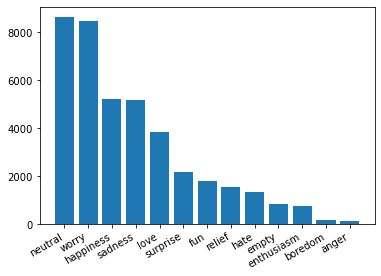

In [3]:
from matplotlib import pyplot as plt

def graphValueCounts(dataset):
  valueCounts = dataset.value_counts()
  fig, ax = plt.subplots()
  plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
  _ = plt.bar(valueCounts.index, valueCounts)

graphValueCounts(TwitterDataset['sentiment'])

## Usefulness of sentiments and class imbalance

In this step, we redefine the  emotions. For example, we merge anger and hate into one value.

In [4]:
# Reload dataset so this cell can be run in succession
TwitterDataset = loadDataset()

# Drop the tweet_id column because we don't need it
TwitterDataset.drop('tweet_id', axis=1, inplace=True)

# Combine 'happiness' and 'fun' into just 'happiness'
TwitterDataset['sentiment'].replace(to_replace='fun', value='happiness', inplace = True)

# Combine 'anger' and 'hate' into just 'anger'
TwitterDataset['sentiment'].replace(to_replace='hate', value='anger', inplace = True)

# Remove 'boredom', 'enthusiasm', 'relief', and 'empty'
TwitterDataset = TwitterDataset[~TwitterDataset['sentiment'].isin(['boredom', 'enthusiasm', 'relief', 'empty'])]

# Reset index so that its ready to be filtered again
TwitterDataset.reset_index(drop=True, inplace=True)

# Show the exact count of each sentiment
print(TwitterDataset['sentiment'].value_counts())

neutral      8638
worry        8459
happiness    6985
sadness      5165
love         3842
surprise     2187
anger        1433
Name: sentiment, dtype: int64


In [5]:
TwitterDataset.info()
TwitterDataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36709 entries, 0 to 36708
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  36709 non-null  object
 1   content    36709 non-null  object
dtypes: object(2)
memory usage: 573.7+ KB


,sentiment,content
count,36709,36709
unique,7,36553
top,neutral,I just received a mothers day card from my lov...
freq,8638,14


sadness      3000
love         3000
neutral      3000
happiness    3000
worry        3000
surprise     2187
anger        1433
Name: sentiment, dtype: int64


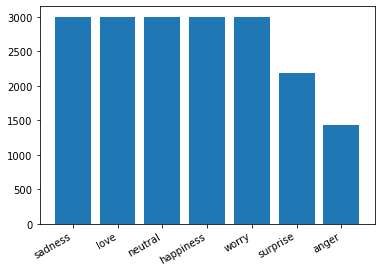

In [6]:
# Randomly select only 3k samples max from each sentiment
cap = 3000
combinedSamplesIndex = pd.Index([])
for sentiment in TwitterDataset['sentiment'].unique():
    # Grab the subset that has this sentiment
    sentimentSubset = TwitterDataset[TwitterDataset['sentiment'] == sentiment]
    # Grab cap random samples from this subset, or keep the old max if its already smaller
    cappedSubset = sentimentSubset.sample(n=min(cap, sentimentSubset.shape[0]), axis=0)
    # Take the indices of these samples from the original dataset and combine them
    combinedSamplesIndex = combinedSamplesIndex.union(cappedSubset.index)
# Now use these combined indices to reduce the dataset
TwitterDataset = TwitterDataset.iloc[combinedSamplesIndex]
# Reset the index again
TwitterDataset.reset_index(drop=True, inplace=True)

# Show the exact count of each now
print(TwitterDataset['sentiment'].value_counts())

# Display new capped sentiment value counts as a graph
graphValueCounts(TwitterDataset['sentiment'])

# EDA
Exploratory Data Analysis (EDA) is an approach to analyze the data using visual techniques. It is used to discover trends, patterns, or to check assumptions with the help of statistical summary and graphical representations.

In [7]:
TwitterDataset['sentiment'].value_counts(normalize=True)

sadness      0.161117
love         0.161117
neutral      0.161117
happiness    0.161117
worry        0.161117
surprise     0.117454
anger        0.076960
Name: sentiment, dtype: float64

In [8]:
TwitterDataset['text_length'] = TwitterDataset['content'].astype(str).apply(len)
TwitterDataset['text_word_count'] = TwitterDataset['content'].apply(lambda x: len(str(x).split()))

/Users/mangeshraut/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


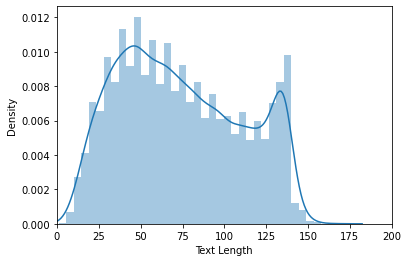

In [9]:
sns.distplot(TwitterDataset['text_length'])
plt.xlim([0, 200]);
plt.xlabel('Text Length');

<AxesSubplot:xlabel='sentiment', ylabel='text_word_count'>

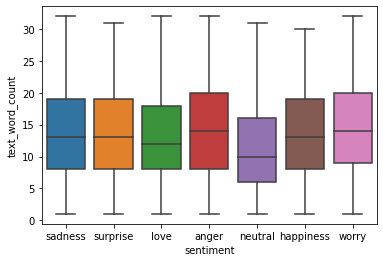

In [10]:
sns.boxplot(x="sentiment", y="text_word_count", data=TwitterDataset)

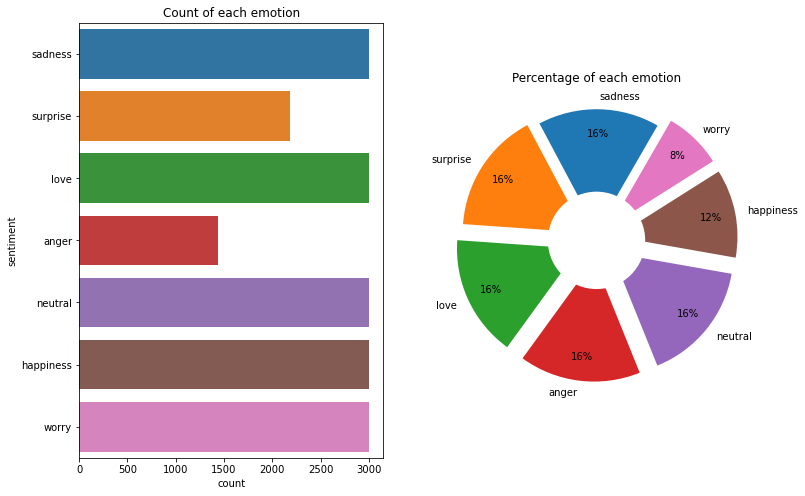

In [11]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(TwitterDataset["sentiment"].dropna().value_counts()))/sum(list(TwitterDataset["sentiment"].dropna().value_counts())))[::-1])[:]
labels = list(TwitterDataset["sentiment"].dropna().unique())[:]
sizes = TwitterDataset["sentiment"].value_counts()[:]

ax2.pie(sizes,  explode=explode, startangle=60, labels=labels, autopct='%1.0f%%', pctdistance=0.8)
ax2.add_artist(plt.Circle((0,0),0.4,fc='white'))
sns.countplot(y="sentiment", data=TwitterDataset, ax=ax1)
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()

In this step, we do sentiment analysis by using Textblob library. Our sentiments are classified as positive, negative, or neutral.

In [12]:
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    if sentiment > 0:
        result = "Positive"
    elif sentiment < 0:
        result = "Negative"
    else:
        result = "Neutral"
    return result     

In [13]:
TwitterDataset["sentiment_emotions"] = TwitterDataset["sentiment"].apply(get_sentiment)

In [14]:
TwitterDataset.head()

,sentiment,content,text_length,text_word_count,sentiment_emotions
0,sadness,Layin n bed with a headache ughhhh...waitin o...,60,10,Neutral
1,sadness,Funeral ceremony...gloomy friday...,35,3,Neutral
2,sadness,"I should be sleep, but im not! thinking about ...",132,26,Neutral
3,sadness,@charviray Charlene my love. I miss you,39,7,Neutral
4,sadness,@kelcouch I'm sorry at least it's Friday?,42,7,Neutral


In [15]:
TwitterDataset.groupby(['sentiment', 'sentiment_emotions']).size()

sentiment  sentiment_emotions
anger      Negative              1433
happiness  Positive              3000
love       Positive              3000
neutral    Neutral               3000
sadness    Neutral               3000
surprise   Neutral               2187
worry      Neutral               3000
dtype: int64

In [16]:
## Show TextBlob classifier metrics and visualizations

/Users/mangeshraut/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/mangeshraut/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


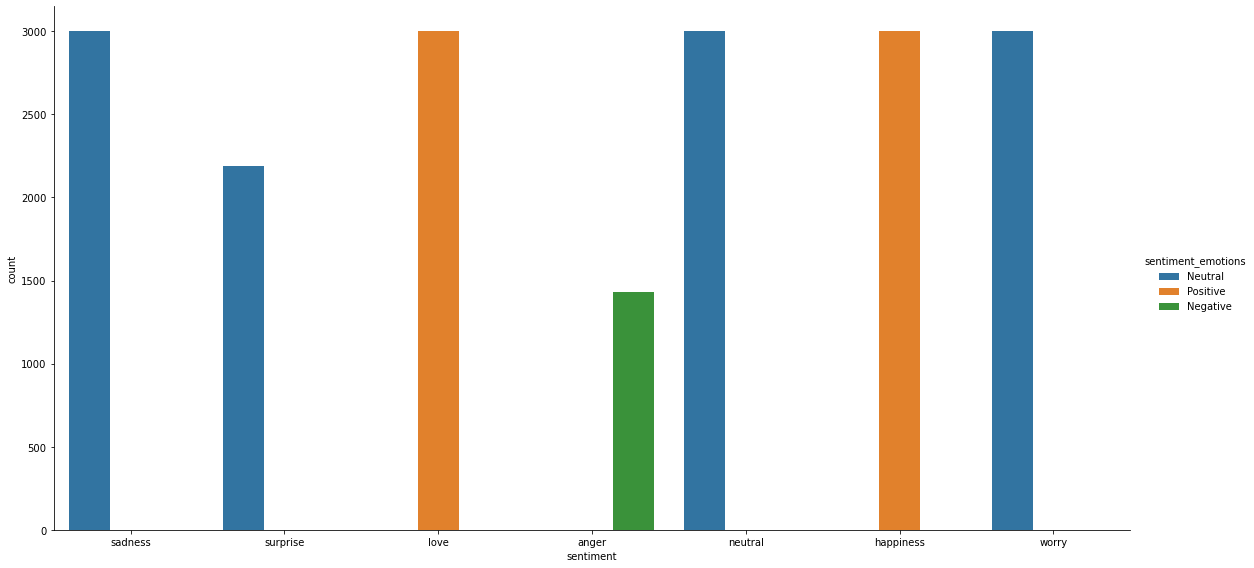

In [17]:
sns.factorplot(x='sentiment',hue='sentiment_emotions',data=TwitterDataset,kind='count',size=8,aspect=2)

## Data cleaning

Data cleaning is one of the most important processes during big data analysis as a tidy dataset that has a clear structure can be easily analyzed, modeled and visualized.

### Cleaning data in preparation for tokenization

Cleaning the dataset is a significant step in our project, as unsanitized text negatively impacts accuracy of our classifier.

In [18]:
print(TwitterDataset[:10])

  sentiment                                            content  text_length  \
0   sadness  Layin n bed with a headache  ughhhh...waitin o...           60   
1   sadness                Funeral ceremony...gloomy friday...           35   
2   sadness  I should be sleep, but im not! thinking about ...          132   
3   sadness            @charviray Charlene my love. I miss you           39   
4   sadness         @kelcouch I'm sorry  at least it's Friday?           42   
5   sadness  Ugh! I have to beat this stupid song to get to...           62   
6  surprise                                       Got the news           12   
7   sadness      The storm is here and the electricity is gone           45   
8      love                               @annarosekerr agreed           20   
9   sadness  So sleepy again and it's not even that late. I...           63   

   text_word_count sentiment_emotions  
0               10            Neutral  
1                3            Neutral  
2         

In [19]:
pip install neattext

Note: you may need to restart the kernel to use updated packages.


Now, we do preprocessing by using regular expression operations (re) function to clean our content. 

In [20]:
import re
import neattext as nt

# Remove obstructions that would hinder tokenization or be hard to remove after
def cleanText(content):
    # Make everything lowercase
    content = content.lower()
    
    # Remove website URLs
    content = re.sub('((https?|ftp|smtp):\/\/)?(www.)?[a-z0-9]+\.[a-z]+(\/[a-z0-9-_#]+\/?)*', ' ', content)

    # Remove ending punctuation and hyphens between words and separate with a space instead
    content = re.sub('(?<=\w)([\.!?,-]+)(?=\w+)',' ', content)
    
    # Remove twitter handles
    content = re.sub('(@\w+)', '', content)
    
    # Use neattext to automate some text cleaning
    tf = nt.TextFrame(content)
    tf.remove_urls()
    
    # Switch to normal regex to remove ending punctuation and hyphens between words
    content = tf.text
    content = re.sub('(?<=\w)([\.!?-]+)(?=\w+)','', content)
    
    # Switch back to neattext for the other functions
    tf = nt.TextFrame(content)
    tf.remove_emails()
    tf.remove_phone_numbers()
    tf.remove_numbers()
    tf.remove_emojis()
#     tf.remove_stopwords()
    
    # Switch to regex to remove twitter handles
    content = tf.text
    content = re.sub('(@\w+)', '', content)
    
    # Use neattext again to remove punctuation
    tf = nt.TextFrame(content)
    tf.remove_special_characters()
    
    # Use regex to undo some texting slang
    content = tf.text
    content = re.sub('(?<=\W)(u)(?=\W)', 'you', content)
    content = re.sub('(?<=\W)(bc)(?=\W)', 'because', content)
    content = re.sub('(?<=\W)(bf)(?=\W)', 'boyfriend', content)
    content = re.sub('(?<=\W)(gf)(?=\W)', 'girlfriend', content)
    content = re.sub('(?<=\W)(n)(?=\W)', 'and', content)
    content = re.sub('(?<=\W)(rn)(?=\W)', 'right now', content)
    content = re.sub('(?<=\W)(r)(?=\W)', 'are', content)
    content = re.sub('(?<=\W)(y)(?=\W)', 'why', content)
    content = re.sub('(?<=\W)(b)(?=\W)', 'be', content)
    content = re.sub('(?<=\W)(w)(?=\W)', 'with', content)
    
    # Remove successive whitespace
    content = re.sub('\s{2,}', ' ', content)
    
    return content

# Create a new object for the processed tweets and print it
CleanDataset = TwitterDataset.copy()
CleanDataset['content'] = CleanDataset['content'].apply(cleanText)

print(CleanDataset[:10])

  sentiment                                            content  text_length  \
0   sadness  layin and bed with a headache ughhhh waitin on...           60   
1   sadness                     funeral ceremony gloomy friday           35   
2   sadness  i should be sleep but im not thinking about an...          132   
3   sadness                        charlene my love i miss you           39   
4   sadness                       im sorry at least its friday           42   
5   sadness  ugh i have to beat this stupid song to get to ...           62   
6  surprise                                       got the news           12   
7   sadness      the storm is here and the electricity is gone           45   
8      love                                             agreed           20   
9   sadness  so sleepy again and its not even that late i f...           63   

   text_word_count sentiment_emotions  
0               10            Neutral  
1                3            Neutral  
2         

In [21]:
TwitterDataset['CleanText'] = CleanDataset['content']

In [22]:
TwitterDataset

,sentiment,content,text_length,text_word_count,sentiment_emotions,CleanText
0,sadness,Layin n bed with a headache ughhhh...waitin o...,60,10,Neutral,layin and bed with a headache ughhhh waitin on...
1,sadness,Funeral ceremony...gloomy friday...,35,3,Neutral,funeral ceremony gloomy friday
2,sadness,"I should be sleep, but im not! thinking about ...",132,26,Neutral,i should be sleep but im not thinking about an...
3,sadness,@charviray Charlene my love. I miss you,39,7,Neutral,charlene my love i miss you
4,sadness,@kelcouch I'm sorry at least it's Friday?,42,7,Neutral,im sorry at least its friday
...,...,...,...,...,...,...
18615,love,His snoring is so annoying n it keeps me from ...,131,28,Positive,his snoring is so annoying and it keeps me fro...
18616,neutral,@lovelylisaj can you give me the link for the ...,67,12,Neutral,can you give me the link for the kimba diarie...
18617,happiness,Succesfully following Tayla!!,29,3,Positive,succesfully following tayla
18618,love,Happy Mothers Day All my love,30,6,Positive,happy mothers day all my love


Below, we extract the keywords of each emotion from our content in seperate dictionaries and visualize the most common words.

In [23]:
def extract_keywords(text,num=50):
    tokens = [ tok for tok in text.split()]
    most_common_tokens = Counter(tokens).most_common(num)
    return dict(most_common_tokens)

In [24]:
emotion_list = TwitterDataset['sentiment'].unique().tolist()
emotion_list

['sadness', 'surprise', 'love', 'anger', 'neutral', 'happiness', 'worry']

In [25]:
surprise_list = TwitterDataset[TwitterDataset['sentiment'] == 'surprise']['CleanText'].tolist()

In [26]:
surprise_list

['got the news',
 ' days of this month left and i only have mb left on my onpeak downloads',
 ' where are you in bris i cant hear any thunder',
 'bec vs fat food winner fat food but not this weeknend ill beat it',
 'i had a dream about a pretty pretty beach and there was no beach when i woke up',
 'when da heck will the garage man get here i ask you when',
 'why am i completing facebook quizzes at this time of the morning especially a friday morning',
 ' epicentre wheelock place units amp for tourists only starting today',
 ' aw you cant let me in on the secret',
 ' im sorry i dont think i stick out at least compared to what i used to look like',
 'is thinking so much and im at work',
 'my gap year is going so quick',
 ' oh no hugs',
 ' dude i just saw your sf pics looks like your mini excursion was pretty kick ass didnt see any sun while i was there tho',
 ' ur supposed to be in bk tho',
 'oh no nighty night',
 ' nope they are all sleeping cuz they live on the east coast',
 'omg i did

In [27]:
surprise_doc = ' '.join(surprise_list)

In [28]:
surprise_doc

'got the news  days of this month left and i only have mb left on my onpeak downloads  where are you in bris i cant hear any thunder bec vs fat food winner fat food but not this weeknend ill beat it i had a dream about a pretty pretty beach and there was no beach when i woke up when da heck will the garage man get here i ask you when why am i completing facebook quizzes at this time of the morning especially a friday morning  epicentre wheelock place units amp for tourists only starting today  aw you cant let me in on the secret  im sorry i dont think i stick out at least compared to what i used to look like is thinking so much and im at work my gap year is going so quick  oh no hugs  dude i just saw your sf pics looks like your mini excursion was pretty kick ass didnt see any sun while i was there tho  ur supposed to be in bk tho oh no nighty night  nope they are all sleeping cuz they live on the east coast omg i didnt tweet all that much today sadness  not really sleepy bored is the 

In [29]:
love_list = TwitterDataset[TwitterDataset['sentiment'] == 'love']['CleanText'].tolist()

In [30]:
love_list

[' agreed',
 ' correct i adore him i just plucked him up and put him under my arm cuz he was cryin all better now hahaha',
 ' sounds good appreciate the suggestion been a week now and were still offline time to ask for a refund',
 ' thanks neemah im gonna be soooo close to you and izzy yet so far',
 ' i missed the game',
 ' love the song quottogetherquot thats quothisquot song for me well i think its still is',
 'i want to go to peru this summer ahhhhhhh hopefully yesyesyes i miss it over there',
 ' i cant wait to hear your new album im sure will be just replay to me i love you so much',
 'theres really no android twitter app of tweeties calibre',
 'the pics i just uploaded are the baby pics of my cats missy is now an adult and a pretty little kitty but batty is in kitten heaven now',
 'photo martwo omg i love you i accadentally deleted this photo yay hes so beautiful ',
 'good time rocking out open mic thanks all the love and support now working on business plan presentation no cg aga

In [31]:
love_doc = ' '.join(love_list)

In [32]:
love_doc

' agreed  correct i adore him i just plucked him up and put him under my arm cuz he was cryin all better now hahaha  sounds good appreciate the suggestion been a week now and were still offline time to ask for a refund  thanks neemah im gonna be soooo close to you and izzy yet so far  i missed the game  love the song quottogetherquot thats quothisquot song for me well i think its still is i want to go to peru this summer ahhhhhhh hopefully yesyesyes i miss it over there  i cant wait to hear your new album im sure will be just replay to me i love you so much theres really no android twitter app of tweeties calibre the pics i just uploaded are the baby pics of my cats missy is now an adult and a pretty little kitty but batty is in kitten heaven now photo martwo omg i love you i accadentally deleted this photo yay hes so beautiful  good time rocking out open mic thanks all the love and support now working on business plan presentation no cg again nite  lol very true maybe next year i looo

In [33]:
anger_list = TwitterDataset[TwitterDataset['sentiment'] == 'anger']['CleanText'].tolist()

In [34]:
anger_list

['it is so annoying when she starts typing on her computer in the middle of the night',
 'dammit hulu desktop has totally screwed up my ability to talk to a particular port on one of our dev servers so i cant watch and code',
 ' cayogial i wanted to come to bz this summer not so sure anymore a teachers life in the summer sucks',
 ' you win sigh rakeem',
 ' damn that sucks',
 ' this website gave me a virus when i opened it more windows kept popping up',
 ' waraku is tasteless and expensive portion is so little re waraku',
 ' youstinkatrespondingtotexts',
 'dont you hate it when you finish all your work and theres still hours left of work time',
 ' umm yeah thats probably a pretty good note to self because eeeeeewwwwwwww',
 ' im doing that shit right now im on vacation and you got me workin',
 'would wish the severe migrains would stop docs prescriptions arent working',
 ' cuz airlines are super lame',
 'im so very tired and have insomnia',
 'i hate bakersfield and i hate the ports let m

In [35]:
anger_doc = ' '.join(anger_list)

In [36]:
anger_doc

'it is so annoying when she starts typing on her computer in the middle of the night dammit hulu desktop has totally screwed up my ability to talk to a particular port on one of our dev servers so i cant watch and code  cayogial i wanted to come to bz this summer not so sure anymore a teachers life in the summer sucks  you win sigh rakeem  damn that sucks  this website gave me a virus when i opened it more windows kept popping up  waraku is tasteless and expensive portion is so little re waraku  youstinkatrespondingtotexts dont you hate it when you finish all your work and theres still hours left of work time  umm yeah thats probably a pretty good note to self because eeeeeewwwwwwww  im doing that shit right now im on vacation and you got me workin would wish the severe migrains would stop docs prescriptions arent working  cuz airlines are super lame im so very tired and have insomnia i hate bakersfield and i hate the ports let me go home already i want to start my vacation i hate the 

In [37]:
keyword_surprise = extract_keywords(surprise_doc)
keyword_surprise

{'i': 1072,
 'to': 694,
 'the': 693,
 'a': 532,
 'you': 497,
 'my': 430,
 'and': 395,
 'it': 378,
 'in': 325,
 'is': 325,
 'that': 275,
 'for': 265,
 'me': 256,
 'of': 251,
 'on': 226,
 'just': 218,
 'im': 211,
 'so': 210,
 'was': 206,
 'have': 179,
 'but': 170,
 'its': 158,
 'not': 157,
 'are': 146,
 'all': 136,
 'no': 135,
 'at': 134,
 'day': 132,
 'with': 131,
 'be': 129,
 'up': 128,
 'this': 124,
 'oh': 122,
 'get': 119,
 'out': 118,
 'what': 117,
 'now': 115,
 'got': 99,
 'cant': 98,
 'like': 97,
 'good': 97,
 'know': 95,
 'really': 94,
 'your': 93,
 'dont': 92,
 'see': 89,
 'going': 87,
 'too': 84,
 'lol': 84,
 'why': 82}

In [38]:
keyword_love = extract_keywords(love_doc)
keyword_love

{'i': 1496,
 'the': 1009,
 'to': 980,
 'you': 977,
 'a': 752,
 'love': 674,
 'my': 644,
 'day': 612,
 'and': 572,
 'happy': 468,
 'mothers': 447,
 'for': 432,
 'it': 413,
 'is': 348,
 'in': 331,
 'so': 309,
 'of': 300,
 'all': 298,
 'have': 291,
 'with': 290,
 'me': 270,
 'on': 261,
 'that': 261,
 'im': 255,
 'good': 245,
 'your': 222,
 'just': 216,
 'but': 196,
 'be': 189,
 'was': 180,
 'are': 171,
 'out': 167,
 'its': 166,
 'at': 147,
 'this': 146,
 'now': 142,
 'thanks': 141,
 'like': 141,
 'too': 138,
 'lol': 129,
 'there': 111,
 'really': 111,
 'great': 111,
 'time': 106,
 'from': 106,
 'see': 105,
 'much': 103,
 'up': 99,
 'amp': 99,
 'one': 99}

In [39]:
keyword_anger = extract_keywords(anger_doc)
keyword_anger

{'i': 918,
 'to': 531,
 'the': 495,
 'a': 394,
 'and': 344,
 'my': 339,
 'it': 248,
 'is': 237,
 'you': 230,
 'in': 219,
 'hate': 211,
 'me': 200,
 'of': 182,
 'that': 181,
 'so': 172,
 'im': 171,
 'for': 163,
 'on': 158,
 'this': 143,
 'have': 138,
 'not': 137,
 'its': 133,
 'just': 132,
 'at': 123,
 'but': 102,
 'like': 99,
 'with': 98,
 'are': 97,
 'up': 96,
 'dont': 95,
 'be': 94,
 'work': 91,
 'now': 87,
 'all': 85,
 'out': 85,
 'get': 85,
 'was': 82,
 'cant': 74,
 'sucks': 73,
 'no': 70,
 'when': 67,
 'really': 67,
 'do': 61,
 'go': 60,
 'got': 59,
 'day': 58,
 'going': 56,
 'am': 55,
 'want': 54,
 'why': 54}

In [40]:
# Show number of total words per sentiment (unique words times their count for that sentiment. graph)

In [41]:
def plot_most_common_words(mydict,emotion_name):
    df_01 = pd.DataFrame(mydict.items(),columns=['tokens','count'])
    plt.figure(figsize=(20,10))
    plt.title("Plot of {} Most common keywords.".format(emotion_name))
    sns.barplot(x='tokens',y='count',data=df_01)
    plt.xticks(rotation=45)
    plt.show()

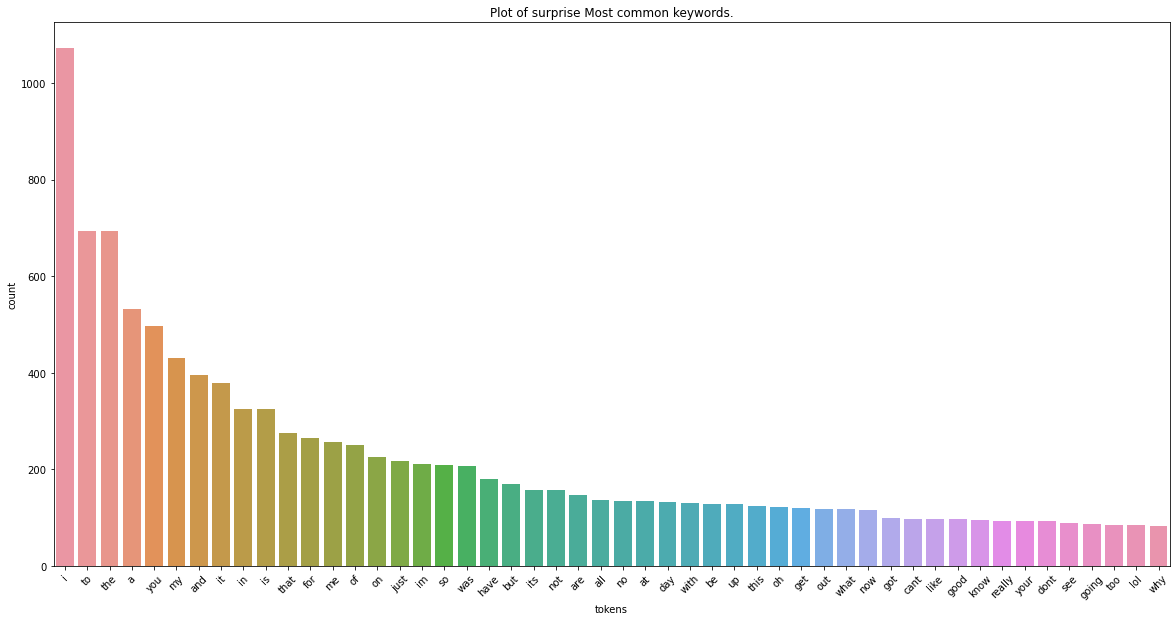

In [42]:
plot_most_common_words(keyword_surprise,"surprise")

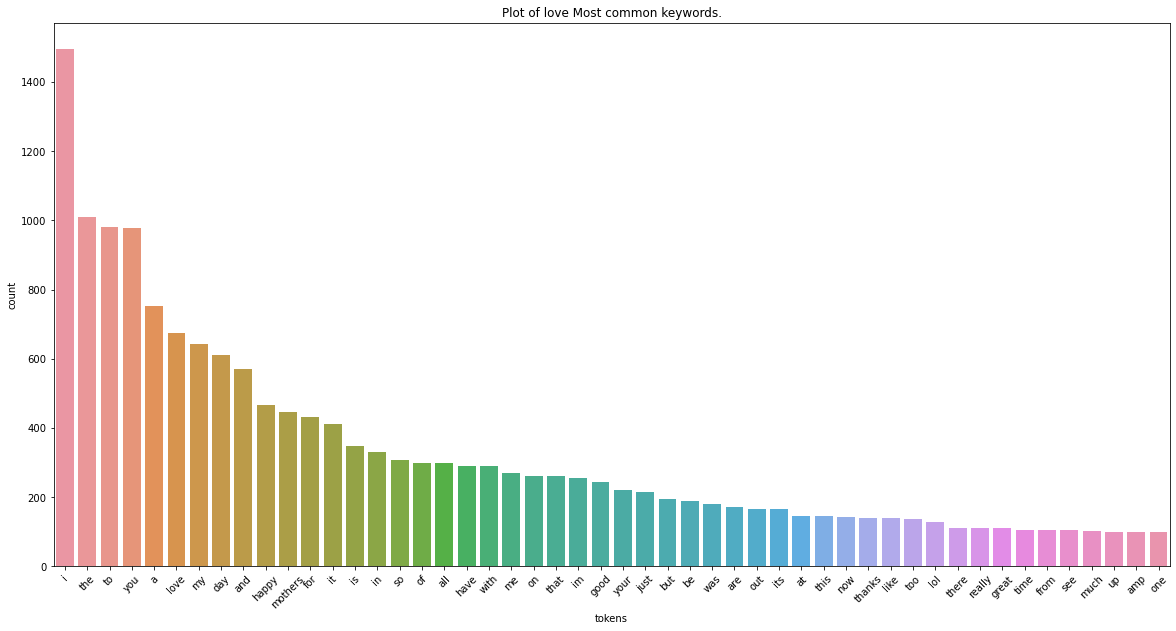

In [43]:
plot_most_common_words(keyword_love,"love")

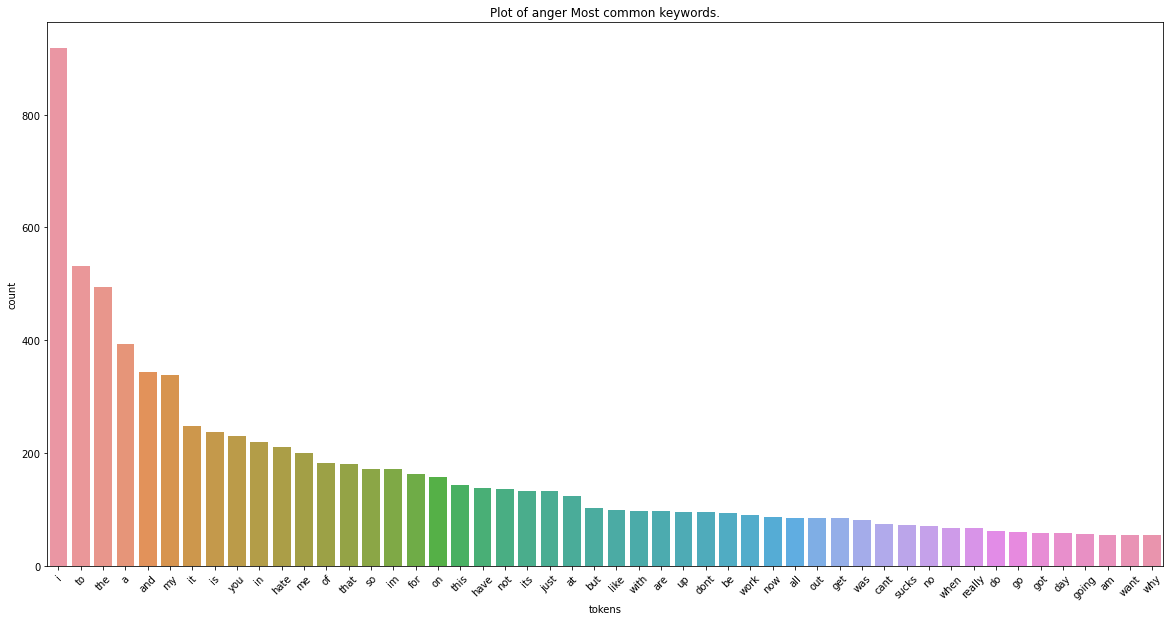

In [44]:
plot_most_common_words(keyword_anger,"anger")

In this step, we use Word Cloud representation technique to represent text data frequency.

In [45]:
# Show number of unique words per sentiment (graph)

In [46]:
def plot_wordcloud(docx):
    mywordcloud = WordCloud().generate(docx)
    plt.figure(figsize=(20,10))
    plt.imshow(mywordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.show()

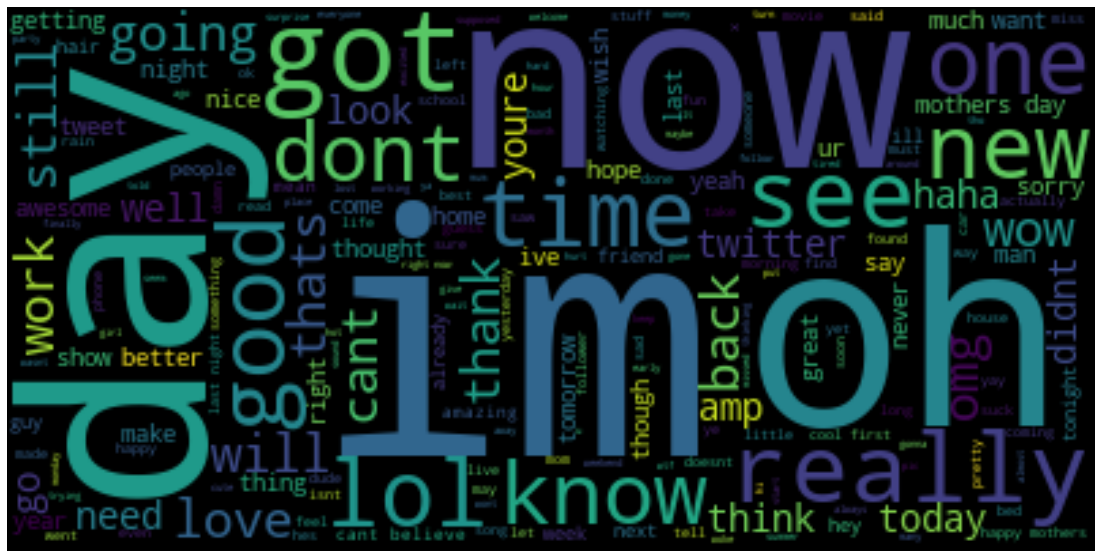

In [47]:
plot_wordcloud(surprise_doc)

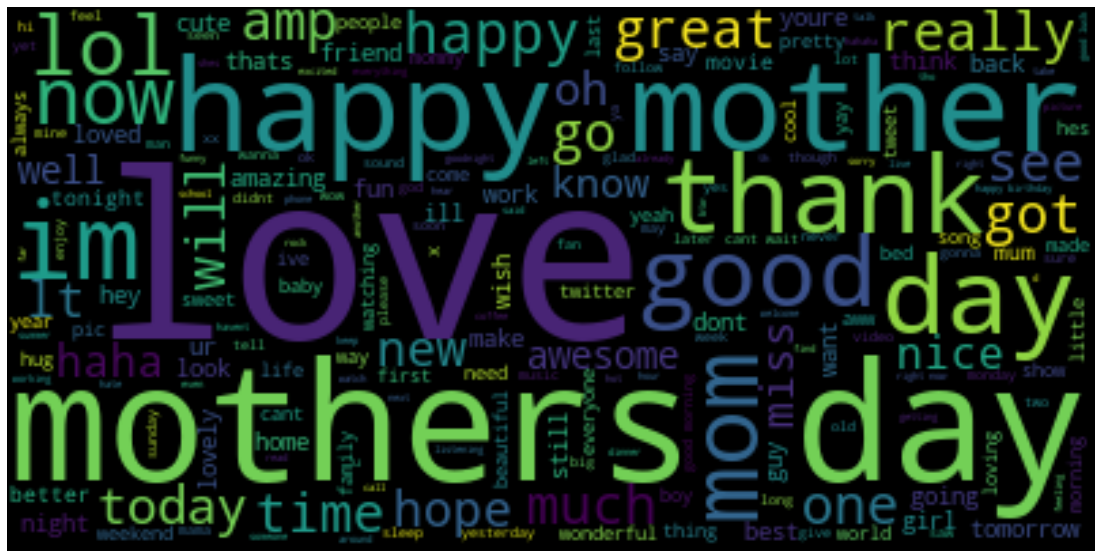

In [48]:
plot_wordcloud(love_doc)

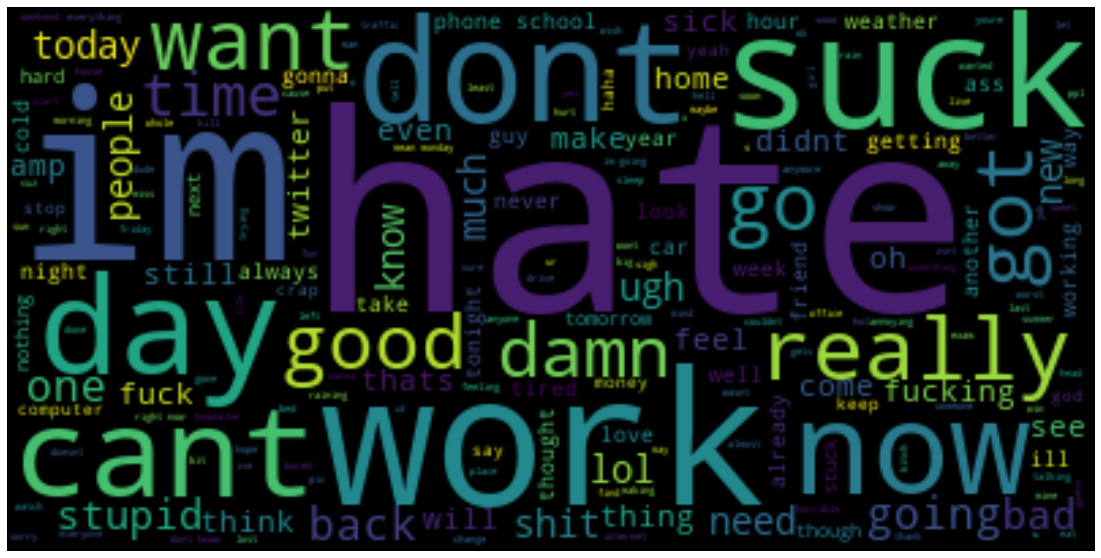

In [49]:
plot_wordcloud(anger_doc)

## Building a statistical model

Here, we use the counter function to supply the values, count frequency of each word in our sentiments and begin building our statistical model by creating a dataframe.

In [50]:
# Count up the number of instances of each word for each sentiment so we have a count of
# each sentiment for each word (words x sentiment dataframe)

from collections import defaultdict
import numpy as np

# Get list of sentiments so we don't have to call this multiple times
sentiments = CleanDataset['sentiment'].unique()

# Create a counter of words for each sentiment
sentimentCounter = {}
for sentiment in sentiments:
    sentimentCounter[sentiment] = defaultdict(int)

# for every word in a tweet, increment that tweet's sentiment counter
for index, tweet in CleanDataset.iterrows():
    for word in tweet['content'].split():
        sentimentCounter[tweet['sentiment']][word] += 1

# Turn these counters into dataframes
sentimentDataFrames = []
for sentiment in sentiments:
    df = pd.DataFrame(sentimentCounter[sentiment].items(), columns=['word', sentiment])
    df.set_index('word', inplace=True)
    sentimentDataFrames.append(df)

# Merge all these dataframes
mergedDataFrame = sentimentDataFrames[0]
for i in range(1,sentiments.shape[0]):
    mergedDataFrame = mergedDataFrame.join(sentimentDataFrames[i])
# Fill all places where a word did not occur for a sentiment with 0
mergedDataFrame.fillna(0, inplace=True)

# Show the dataframe with a count of every time a word was used in a tweet for each sentiment
print(mergedDataFrame)

         sadness  surprise   love  anger  neutral  happiness  worry
word                                                               
layin          1       0.0    0.0    0.0      0.0        0.0    0.0
and          640     395.0  572.0  344.0    487.0      602.0  623.0
bed           34      18.0   33.0   12.0     45.0       45.0   28.0
with         191     131.0  290.0   98.0    205.0      309.0  194.0
a            678     532.0  752.0  394.0    612.0      828.0  776.0
...          ...       ...    ...    ...      ...        ...    ...
alright        1       3.0    5.0    0.0      5.0        3.0    8.0
danger         1       0.0    1.0    0.0      0.0        0.0    0.0
keen           1       0.0    4.0    0.0      0.0        0.0    1.0
dining         1       0.0    0.0    0.0      1.0        0.0    0.0
sisch          1       0.0    0.0    0.0      0.0        0.0    0.0

[5879 rows x 7 columns]


In [51]:
# Turn this dataframe from discrete counts to a probability distribution with an extra column for the total
total = mergedDataFrame.sum(axis=1)
wordStatistics = mergedDataFrame / mergedDataFrame.sum(axis=0)
wordStatistics['total'] = total

# Show the final statistics model
print(wordStatistics)

          sadness  surprise      love     anger   neutral  happiness  \
word                                                                   
layin    0.000025  0.000000  0.000000  0.000000  0.000000   0.000000   
and      0.016107  0.016033  0.017141  0.019760  0.017745   0.017797   
bed      0.000856  0.000731  0.000989  0.000689  0.001640   0.001330   
with     0.004807  0.005317  0.008690  0.005629  0.007470   0.009135   
a        0.017063  0.021594  0.022535  0.022632  0.022300   0.024478   
...           ...       ...       ...       ...       ...        ...   
alright  0.000025  0.000122  0.000150  0.000000  0.000182   0.000089   
danger   0.000025  0.000000  0.000030  0.000000  0.000000   0.000000   
keen     0.000025  0.000000  0.000120  0.000000  0.000000   0.000000   
dining   0.000025  0.000000  0.000000  0.000000  0.000036   0.000000   
sisch    0.000025  0.000000  0.000000  0.000000  0.000000   0.000000   

            worry   total  
word                       
layin  

In [52]:
CleanDataset.describe()

,text_length,text_word_count
count,18620.000000,18620.000000
mean,74.075510,13.352148
std,36.476548,6.934216
min,1.000000,1.000000
25%,44.000000,8.000000
50%,69.000000,12.000000
75%,104.000000,19.000000
max,167.000000,32.000000


In [53]:
# Show that we no longer have any NANs
print(mergedDataFrame.isna().sum())

sadness      0
surprise     0
love         0
anger        0
neutral      0
happiness    0
worry        0
dtype: int64


In [54]:
# Show cleaned words
CleanDataset['content']

0        layin and bed with a headache ughhhh waitin on...
1                           funeral ceremony gloomy friday
2        i should be sleep but im not thinking about an...
3                              charlene my love i miss you
4                             im sorry at least its friday
                               ...                        
18615    his snoring is so annoying and it keeps me fro...
18616     can you give me the link for the kimba diarie...
18617                          succesfully following tayla
18618                        happy mothers day all my love
18619     bullet train from tokyo the girlfriend and i ...
Name: content, Length: 18620, dtype: object

In [55]:
# Show top 10 words with highest count for each sentiment (can be reverse engineered by probability x total count)


## Tweet text sentiment classification using Naive Bayes and Logistic Regression

In this project, we employed Naive Bayes and Logistic Regression methods to classify our sentiments.

## Naive Bayes Model
Naive Bayes is a probabilistic machine learning method that is used for classification. This method is based on the Bayes theorem.

In [56]:
#build features from our data
Xfeatures = TwitterDataset['CleanText']
ylabels = TwitterDataset['sentiment']

In [57]:
Xfeatures

0        layin and bed with a headache ughhhh waitin on...
1                           funeral ceremony gloomy friday
2        i should be sleep but im not thinking about an...
3                              charlene my love i miss you
4                             im sorry at least its friday
                               ...                        
18615    his snoring is so annoying and it keeps me fro...
18616     can you give me the link for the kimba diarie...
18617                          succesfully following tayla
18618                        happy mothers day all my love
18619     bullet train from tokyo the girlfriend and i ...
Name: CleanText, Length: 18620, dtype: object

In [58]:
#Vectorizer
cv = CountVectorizer()
X = cv.fit_transform(Xfeatures)

In [59]:
#to dense array(Numpy)
X.toarray

<bound method _cs_matrix.toarray of <18620x19608 sparse matrix of type '<class 'numpy.int64'>'
	with 210966 stored elements in Compressed Sparse Row format>>

In [60]:
#split dataset
X_train,X_test,y_train,y_test = train_test_split(X,ylabels,test_size=0.5,random_state=45)

In [61]:
#build our model
nv_model = MultinomialNB()
nv_model.fit(X_train,y_train)

MultinomialNB()

In [62]:
#accuracy
nv_model.score(X_test,y_test)

0.32277121374865736

In [63]:
#predictions
y_pred_for_nv = nv_model.predict(X_test)
y_pred_for_nv

array(['sadness', 'worry', 'worry', ..., 'happiness', 'worry',
       'happiness'], dtype='<U9')

In [64]:
sample_text = ["I love coding"]

In [65]:
vect = cv.transform(sample_text).toarray()

In [66]:
#make prediction
nv_model.predict(vect)

array(['love'], dtype='<U9')

In [67]:
#check for prediction probability (percentage)/confidence score
nv_model.predict_proba(vect)

array([[0.02755409, 0.10029836, 0.56584764, 0.09792714, 0.05910409,
        0.04173272, 0.10753597]])

In [68]:
np.max(nv_model.predict_proba(vect))

0.5658476364466619

In [69]:
#model classification
# Show NB metrics and visualizations
print(classification_report(y_test,y_pred_for_nv))

              precision    recall  f1-score   support

       anger       0.49      0.05      0.09       713
   happiness       0.34      0.40      0.37      1474
        love       0.46      0.52      0.48      1493
     neutral       0.34      0.15      0.21      1485
     sadness       0.29      0.49      0.36      1490
    surprise       0.31      0.05      0.08      1139
       worry       0.25      0.40      0.31      1516

    accuracy                           0.32      9310
   macro avg       0.35      0.29      0.27      9310
weighted avg       0.34      0.32      0.29      9310



### Logistic Regression

Logistic Regression is a statistical Machine Learning method which is used for classification. This method is based on the concept of probability.

In [70]:
# Build Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train,y_train)

/Users/mangeshraut/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [71]:
#accuracy
lr_model.score(X_test,y_test)

0.3422126745435016

In [72]:
vect = cv.transform(sample_text).toarray()

In [73]:
def predict_emotion(smaple_text,model):
    myvect = cv.transform(sample_text).toarray()
    prediction = model.predict(myvect)
    pred_prob = model.predict_proba(myvect)
    pred_percentage_for_all = dict(zip(model.classes_,pred_prob[0]))
    print("Prediction:{},Prediction Score:{}".format(prediction[0],np.max(pred_prob)))
    print(prediction[0])
    return pred_percentage_for_all

In [74]:
# predicting emotion using processed text
predict_emotion(sample_text,lr_model)

Prediction:love,Prediction Score:0.6006627922489228
love


{'anger': 0.025758433833014103,
 'happiness': 0.0703381597104503,
 'love': 0.6006627922489228,
 'neutral': 0.1275095280011634,
 'sadness': 0.0433328594221312,
 'surprise': 0.039116263851956115,
 'worry': 0.09328196293236207}

In [75]:
# Predicting emotion using vectorized array text
predict_emotion(vect,lr_model)

Prediction:love,Prediction Score:0.6006627922489228
love


{'anger': 0.025758433833014103,
 'happiness': 0.0703381597104503,
 'love': 0.6006627922489228,
 'neutral': 0.1275095280011634,
 'sadness': 0.0433328594221312,
 'surprise': 0.039116263851956115,
 'worry': 0.09328196293236207}

In [76]:
# Show LR metrics and visualizations
print(classification_report(y_test, y_train))

              precision    recall  f1-score   support

       anger       0.07      0.07      0.07       713
   happiness       0.17      0.17      0.17      1474
        love       0.18      0.18      0.18      1493
     neutral       0.16      0.16      0.16      1485
     sadness       0.17      0.17      0.17      1490
    surprise       0.12      0.11      0.11      1139
       worry       0.16      0.16      0.16      1516

    accuracy                           0.15      9310
   macro avg       0.15      0.15      0.15      9310
weighted avg       0.15      0.15      0.15      9310



## Conclusion

In the first step, a function is defined to load our dataset so it can be counted and visualized. Afterward, the frequency of each sentiment is calculated, and statistical modeling begins. Finally, naive Bayes and logistic regression methods are employed to classify our sentiments.

Emotion Detection can be seen as an important field of research in modern times in human-computer interaction. In this project, modules and methods that are currently being used to detect emotions from text are reviewed along with their limitations. A new system architecture is proposed, which would perform efficiently.

## Future work

Stuff we could do to improve this demonstration but didn't have time/resources for. Add more of what you can think of

* Get more data for less common emotions
* Get a better workflow and more automated tools to clean the text
* Create secondary Neural Networks model to determine influence of each word to accuracy of classifiers to improve metrics

# Citation
Emotion Detection from Text, Kaggle, January 24, 2021,

https://www.kaggle.com/datasets/pashupatigupta/emotion-detection-from-text

Emotion Detection of Text Using Machine Learning and Python, YouTube, April 29, 2021, 

https://youtu.be/t1TkAcSDsI8
